In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy.optimize as optimize
import theano
import theano.tensor as T
from theano import pp
from theano import In

% matplotlib inline

import matplotlib as mpl

print mpl.style.available
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


[u'seaborn-darkgrid', u'Solarize_Light2', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'fast', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']


In [2]:
## define your image grid

x = np.arange(128)
xx, yy = np.meshgrid(x,x)

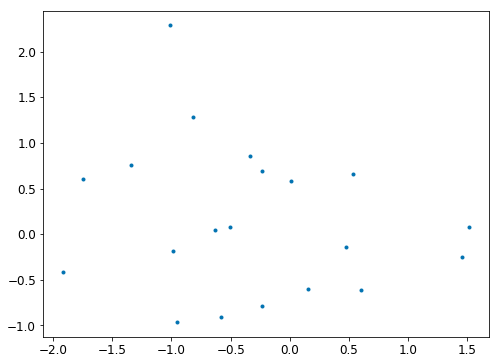

In [3]:
## define your interferometric array

coords = np.random.randn(20,2)
plt.plot(coords[:,0],coords[:,1],'.')

In [4]:
## create your baselines - copied from pysco
ndgt = 6 # number of digits of precision for rounding
prec = 10**(-ndgt)

nbh = coords.shape[0] # local representation of the class variable
uvx = np.zeros(nbh * (nbh-1)) # prepare empty arrays to store
uvy = np.zeros(nbh * (nbh-1)) # the baselines

k = 0 # index for possible combinations (k = f(i,j))

uvi = np.zeros(nbh * (nbh-1), dtype=int) # arrays to store the possible
uvj = np.zeros(nbh * (nbh-1), dtype=int) # combinations k=f(i,j) !!

for i in range(nbh):     # do all the possible combinations of
    for j in range(nbh): # sub-apertures
        if i != j:
            uvx[k] = coords[i,0] - coords[j,0]
            uvy[k] = coords[i,1] - coords[j,1]
            # ---
            uvi[k], uvj[k] = i, j
            k+=1

a = np.unique(np.round(uvx, ndgt)) # distinct u-component of baselines
nbx = a.shape[0]    # number of distinct u-components
uv_sel = np.zeros((0,2))           # array for "selected" baselines

for i in range(nbx):     # identify distinct v-coords and fill uv_sel
    b = np.where(np.abs(uvx - a[i]) <= prec)
    c = np.unique(np.round(uvy[b], ndgt))
    nby = np.shape(c)[0] # number of distinct v-compoments
    app = np.ones(nby)*a[i]
    uv_sel = np.append(uv_sel, np.array([app,c]).T, axis=0)

# hack

uv_sel = 0.1*uv_sel

Text(0,0.5,u'$v$')

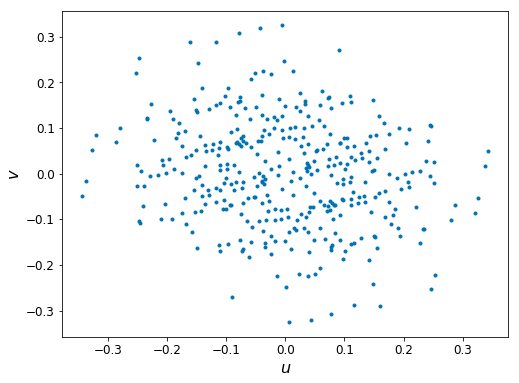

In [5]:
plt.plot(uv_sel[:,0],uv_sel[:,1],'.')
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')

In [31]:
## create p2vm matrix

p2vm_sin = np.zeros((uv_sel.shape[0],xx.ravel().shape[0]))

for j in range(uv_sel.shape[0]):
    p2vm_sin[j,:] = np.ravel(np.sin(xx*uv_sel[j,0]+yy*uv_sel[j,1]))
    
p2vm_cos = np.zeros((uv_sel.shape[0],xx.ravel().shape[0]))

for j in range(uv_sel.shape[0]):
    p2vm_cos[j,:] = np.ravel(np.cos(xx*uv_sel[j,0]+yy*uv_sel[j,1]))

In [32]:
## define gaussian image - from halophot

def gaussian_psf(pixels,xp,yp,width):
    # make rr array
    npix = np.shape(pixels[0])[0]
    xx,yy = np.meshgrid(np.arange(npix)-npix/2.,np.arange(npix)-npix/2.)
    rr2 = (xx-xp)**2 + (yy-yp)**2
    
    return 1./(width*np.sqrt(2.*np.pi))*np.exp(-0.5*(rr2/width**2))

def normalize(vector):
    return (vector-vector.min())/(vector.max()-vector.min())

In [33]:
widths = [5,10,20,20]
xs = [20,-20,-50,90]
ys = [20,60,20,-60]
fs = [5,10,20,30]

In [132]:
image = np.zeros_like(xx)*1.
pixels = np.zeros_like(xx)
for j, w in enumerate(widths):
    image += fs[j]*gaussian_psf(pixels,xs[j]/2.,ys[j]/2.,w/2.)
    
image = normalize(image)
# image /= image.sum()

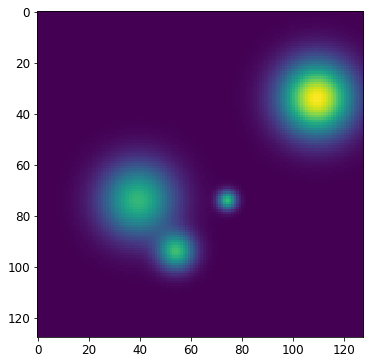

In [133]:
plt.imshow(image)

In [134]:
data_sin = np.dot(p2vm_sin,image.ravel())
data_cos = np.dot(p2vm_cos,image.ravel())

In [157]:
### straight fourier reconstruction

recon = np.zeros_like(image)*1.

for j in range(data_sin.shape[0]):
    recon +=  data_sin[j]*(np.sin(xx*uv_sel[j,0]+yy*uv_sel[j,1]))
    recon +=  data_cos[j]*(np.cos(xx*uv_sel[j,0]+yy*uv_sel[j,1]))


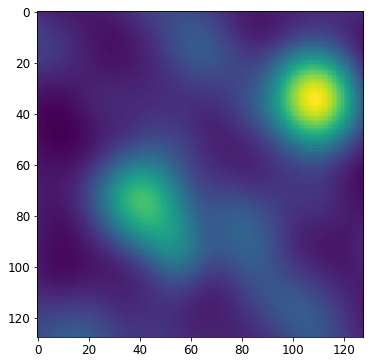

In [158]:
plt.imshow(recon,interpolation='None')

## Now we want to try using a TensorFlow regularized image reconstruction code to do a better job

In [137]:
import tensorflow as tf
print("Using TensorFlow version {0}".format(tf.__version__))
T = tf.float64
cosmat = p2vm_cos.T
sinmat = p2vm_sin.T
cos_obs = data_cos
sin_obs = data_sin
arr = image
arr = 0.9999999999*arr +1e-15
toy = recon

Using TensorFlow version 1.7.0-dev20180223


In [159]:
# create tensor to hold cosine and sine projection operators
cos_tensor = tf.constant(cosmat,dtype=T)
sin_tensor = tf.constant(sinmat,dtype=T)

# create tensor to hold your data
cosobs_tensor = tf.constant(cos_obs,dtype=T)
sinobs_tensor = tf.constant(sin_obs,dtype=T)

# create tensor to hold cosine and sine projection operators
cos_err_tensor = tf.constant(np.median(cos_obs)/5.,dtype=T)
sin_err_tensor = tf.constant(np.median(np.abs(sin_obs))/5.,dtype=T) # sines are symmetric

# create tensor to hold your image model
image_tensor = tf.Variable(normalize(recon[:,:,np.newaxis])+1e-15,dtype=T)

# create constant to hold your entropy tuning parameter

ent_alpha = tf.constant(0,dtype=T)
nx = tf.constant(128,dtype=T)

In [161]:
def tf_log_like(image,cos_op,sin_op,cos_data,sin_data,cos_err,sin_err):
    dummy = tf.reshape(image,[-1])
    sin_model = tf.tensordot(dummy,sin_op,axes=1)
    cos_model = tf.tensordot(dummy,cos_op,axes=1)
    chi2 = -0.5*tf.reduce_sum(((sin_data-sin_model))**2 + ((cos_data-cos_model))**2)
    return chi2


log_like = tf_log_like(image_tensor,cos_tensor,sin_tensor,cosobs_tensor,sinobs_tensor,cos_err_tensor,sin_err_tensor)

In [162]:
# Test our likelihood function

feed_dict = {
    image_tensor: (toy[:,:,np.newaxis]),  
}


with tf.Session() as session:
    # This step is needed to set up the variables.
    session.run(tf.global_variables_initializer())
    
    # And compute the log likelihood.
    print("Log-likelihood computed using tensorflow: {0}"
          .format(session.run(log_like,feed_dict=feed_dict)))

Log-likelihood computed using tensorflow: -3.54854221076e+17


In [163]:
# Test our entropy function

def tf_entropy(image):
    dummy = tf.reshape(image,[-1])
    image_normed = tf.nn.softmax(dummy)
    return tf.reduce_sum(image_normed*tf.log(image_normed), axis=[0])


feed_dict = {
    image_tensor: (arr[:,:,np.newaxis]),  
}

entropy = tf_entropy(image_tensor)

with tf.Session() as session:
    # This step is needed to set up the variables.
    session.run(tf.global_variables_initializer())
    
    # And compute the log likelihood.
    print("Entropy computed using tensorflow: {0}"
          .format(session.run(entropy,feed_dict=feed_dict)))

Entropy computed using tensorflow: -9.68622917868


In [171]:
%%time

# create constant to hold your TV tuning parameter
entropy_alpha = tf.constant(1e-1,dtype=T)

neg_log_like = -log_like + entropy_alpha*entropy

opt = tf.contrib.opt.ScipyOptimizerInterface(
    neg_log_like, var_list=[image_tensor])

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    print("Initial neg-log likelihood: {0}".format(session.run(neg_log_like)))
    opt.minimize(session)
    print("Final neglog likelihood: {0}\n".format(session.run(neg_log_like)))
    
    params = session.run([image_tensor])
final_im = params[0][:,:,0]

Initial neg-log likelihood: 19464842.8515
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: -0.968493
  Number of iterations: 11747
  Number of functions evaluations: 12088
Final neglog likelihood: -0.968493486461

CPU times: user 5min 48s, sys: 17.5 s, total: 6min 5s
Wall time: 3min 18s


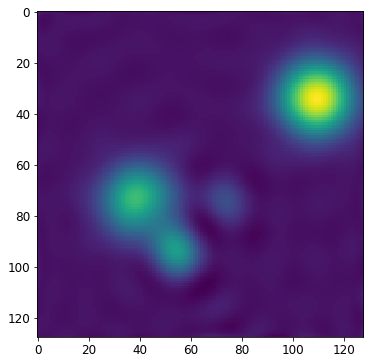

In [172]:
plt.imshow(final_im)

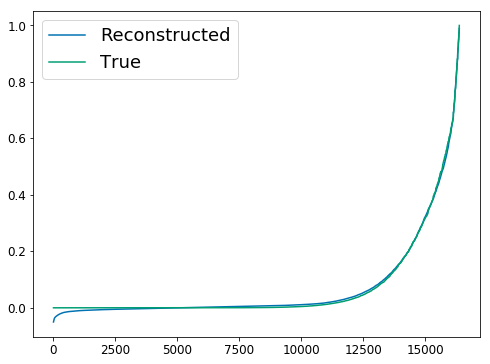

In [173]:
plt.plot(np.sort(final_im.ravel()),label="Reconstructed")
plt.plot(np.sort(image.ravel()),label="True")
plt.legend()